In [101]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


year = [1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335] #first day of month
lyear = [1, 32, 61, 92, 122, 153, 183, 214, 245, 275, 306, 336] #for leap years
monthnames = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']


class Day:
    def __init__(self, use):
        self.season = "winter"
        self.weekday = "weekday"
        self.use = use
        self.dayuse = sum(self.use)
        
    def setSeason(self, season):
        self.season = season
    
    def setDay(self, weekday):
        self.weekday = weekday

In [102]:
def createYear(dataframe, column):
    daylist = []
    use = []
    for i in range(1, dataframe.shape[0] + 1):
        use.append(dataframe.loc[i - 1, column])
        if i%24 == 0:
            daylist.append(Day(use))
            use = []
    return daylist

def distributeWeekday(daylist, jan1): #change day of week for first day of the year (monday = 1, tuesday = 2, ...sunday = 7)
    for day in daylist:
        if jan1%7 == 6 or jan1%7 == 0:
            day.weekday = 'weekend'
        jan1 = jan1 + 1
        
def distributeSeason(daylist):
    i = 1
    for day in daylist:
        if i >= year[5] and i < year[9]:
            day.season = 'summer'
        i = i + 1

In [103]:
customersumm = pd.read_csv('anonymized_1in10_actual_actual_2014_cluster_summary.csv', index_col=1, header=0)
filename = 'pge-res-PGFG-res_misc-noKW-nonCare-0.5_0.6' #change to appropriate filename WITHOUT .csv tag
customers = int(customersumm.loc[filename, 'customer_count'])

df = pd.read_csv(filename+'.csv')
df['total'] = df['total']/customers
df_year = createYear(df, 'total')
distributeSeason(df_year)
distributeWeekday(df_year, 3)

In [104]:
sh = "HP_SH_HourlyProfiles.csv"
wh = "HP_WH_HourlyProfiles.csv"

df_sh = pd.read_csv(sh)
sh_year = createYear(df_sh, '3')
distributeSeason(sh_year)
distributeWeekday(sh_year, 3)


df_wh = pd.read_csv(wh)
wh_year = createYear(df_wh, '3')
distributeSeason(sh_year)
distributeWeekday(sh_year, 3)

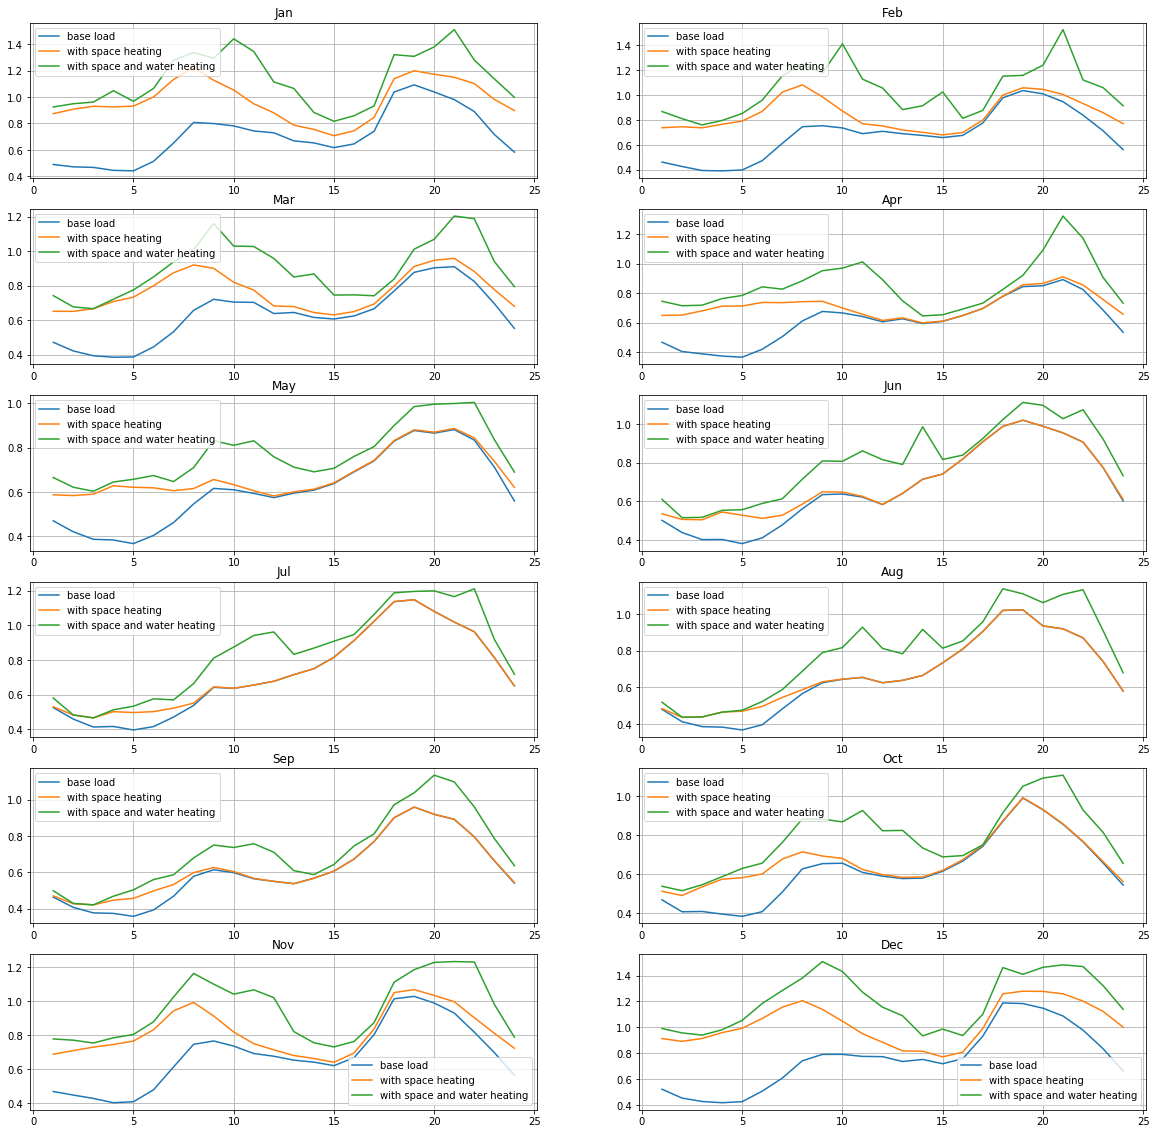

In [108]:
def graphYear(year, sh_year, wh_year, yeardays):
    plt.figure(figsize = (20,20))
    for i in range(1, len(yeardays) + 1):
        plt.subplot(6, 2, i)
        if i == 12:
            y, y1, y2 = monthAvg(year[yeardays[i-1]:366], sh_year[yeardays[i-1]:366], wh_year[yeardays[i-1]:366])
            graphMonth(y, y1, y2)
        else: 
            y, y1, y2 = monthAvg(year[yeardays[i-1]:yeardays[i]], sh_year[yeardays[i-1]:yeardays[i]], wh_year[yeardays[i-1]:yeardays[i]])
            graphMonth(y, y1, y2)
        plt.grid(True)
        plt.title(monthnames[i - 1])
    plt.show()

def graphMonth(y, y1, y2):
    x = range(1, 25)
    plt.plot(x, y, label='base load')
    plt.plot(x, y1 + y, label = 'with space heating')
    plt.plot(x, y2 + y1 + y, label = 'with space and water heating')
    plt.legend()
            
def monthAvg(year, sh_year, wh_year):
    hourlyAvg = np.zeros(24)
    hourlyAvgSH = np.zeros(24)
    hourlyAvgWH = np.zeros(24)
    for i in range(0, len(year)):
        for j in range(0, 24):
            hourlyAvg[j] = hourlyAvg[j] + year[i].use[j]
            hourlyAvgSH[j] = hourlyAvgSH[j] + sh_year[i].use[j]
            hourlyAvgWH[j] = hourlyAvgWH[j] + wh_year[i].use[j]
    hourlyAvg = hourlyAvg/len(year)
    hourlyAvgSH = hourlyAvgSH/len(year)
    hourlyAvgWH = hourlyAvgWH/len(year)
    return hourlyAvg, hourlyAvgSH, hourlyAvgWH

graphYear(df_year, sh_year, wh_year, year)

In [106]:
def flat(daylist, price=0.19):
    totaluse = 0
    for day in daylist:
        totaluse = totaluse + day.dayuse
    return totaluse * price


def tier(daylist, baseline=15, tier1=0.22376, tier2=0.28159, tier3=0.49334):
    # https://www.pge.com/tariffs/assets/pdf/tariffbook/ELEC_SCHEDS_E-1.pdf
    monthlyuse = []
    i = 1
    totaluse = 0
    for day in daylist:
        totaluse = totaluse + day.dayuse
        if i in year:
            monthlyuse.append(totaluse)
            totaluse = 0
    totalcost = 0
    for month in monthlyuse:
        totalcost = totalcost + min(baseline, month) * tier1 + max(0, month - baseline) * tier2 + max(0, month - 4*baseline) * tier3
    return totalcost


def tou(daylist, speak=0.25354, soffpeak=0.20657, wpeak=0.18022, woffpeak=0.17133):
    # https://www.pge.com/tariffs/assets/pdf/tariffbook/ELEC_SCHEDS_EL-TOU.pdf
    speaksum = 0
    soffpeaksum = 0
    wpeaksum = 0
    woffpeaksum = 0
    for day in daylist:
        if day.season == "summer":
            if day.weekday == "weekday":
                speaksum = speaksum + sum(day.use[14:19])
                soffpeaksum = soffpeaksum + sum(day.use[:14]) + sum(day.use[19:])
            else:
                soffpeaksum = soffpeaksum + day.dayuse
        else:
            if day.weekday == "weekday":
                wpeaksum = wpeaksum + sum(day.use[14:19])
                woffpeaksum = woffpeaksum + sum(day.use[:14]) + sum(day.use[19:])
            else:
                woffpeaksum = woffpeaksum + day.dayuse
    return speaksum * speak + soffpeaksum * soffpeak + wpeaksum * wpeak + woffpeaksum * woffpeak


print("Yearly energy costs under flat rate plan: $%f" % flat(df_year))
print("Yearly energy costs under tiered rate plan: $%f" % tier(df_year))
print("Yearly energy costs under time of use rate plan: $%f" % tou(df_year))

yearuse = 0
for day in df_year:
    yearuse = yearuse + day.dayuse
ppkwh = min(flat(df_year), tier(df_year), tou(df_year))/yearuse
print("$/kWh under the cheapest plan: $%f" % ppkwh)

Yearly energy costs under flat rate plan: $1105.124325
Yearly energy costs under tiered rate plan: $1327.576442
Yearly energy costs under time of use rate plan: $1088.998491
$/kWh under the cheapest plan: $0.187228


In [107]:
# graph avg weekday/weekend in each month : base load, water heating (hp_wh), space heating (hp_sh)
# avg $/kwh for lowest user, highest user
# new dataset, use climate zone 3 
# https://stackoverflow.com/questions/9847213/how-do-i-get-the-day-of-week-given-a-date-in-python